This notebook will utilize the cleaned dataframe and work on feature extraction using tf-idf vectors and working on Machine Learning models on it.

In [4]:
# imports

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

In [5]:
def load_and_clean_data(file_path):
    """Load data and handle all types of missing values"""
    df = pd.read_csv(file_path)
    
    print(f"Initial shape: {df.shape}")
    
    # Remove rows where any of the text columns have issues
    text_columns = ['text', 'text_tfidf', 'text_bert']
    
    for col in text_columns:
        if col in df.columns:
            # Remove NaN
            df = df[df[col].notna()]
            # Remove empty strings
            df = df[df[col] != '']
    
    print(f"Final shape after cleaning: {df.shape}")
    return df

df = load_and_clean_data('data/cleaned_df.csv')

Initial shape: (41563, 6)
Final shape after cleaning: (41544, 6)


In [6]:
print(df.isnull().sum())

text           0
label          0
text_length    0
word_count     0
text_tfidf     0
text_bert      0
dtype: int64


In [7]:
# Split for TF-IDF models (80% train, 20% test)
X = df['text_tfidf']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

Train size: 33235
Test size: 8309


### Feature Extraction with TF-IDF

In [9]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # unigrams and bigrams
    min_df=1,            # ignore terms that appear in less than 1 document
    max_df=0.8,          # ignore terms that appear in more than 80% of documents
    stop_words='english'
)

In [10]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF features - Train: {X_train_tfidf.shape}, Test: {X_test_tfidf.shape}")

TF-IDF features - Train: (33235, 5000), Test: (8309, 5000)


### Rule Based Sentiment Analysis

Rule-based Accuracy: 0.7851

Rule-based Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.78      0.78      4033
    Positive       0.79      0.79      0.79      4276

    accuracy                           0.79      8309
   macro avg       0.78      0.78      0.78      8309
weighted avg       0.79      0.79      0.79      8309



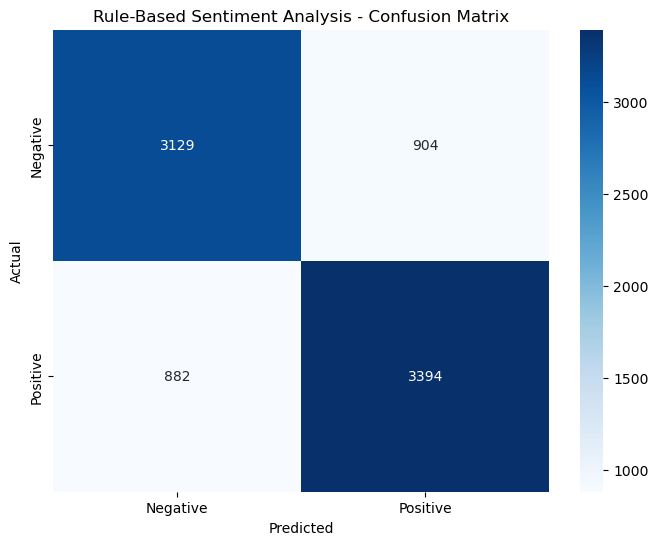

In [13]:
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon if needed
try:
    nltk.download('vader_lexicon', quiet=True)
except:
    print("VADER lexicon download failed, but will try to use if already available")

class RuleBasedSentiment:
    def __init__(self):
        try:
            self.sia = SentimentIntensityAnalyzer()
            self.vader_available = True
        except:
            self.vader_available = False
            print("VADER not available, using TextBlob only")
        
    def textblob_analysis(self, text):
        """Analyze sentiment using TextBlob"""
        try:
            analysis = TextBlob(str(text))
            return analysis.sentiment.polarity
        except:
            return 0.0
    
    def vader_analysis(self, text):
        """Analyze sentiment using VADER"""
        if not self.vader_available:
            return 0.0
        try:
            scores = self.sia.polarity_scores(str(text))
            return scores['compound']
        except:
            return 0.0
    
    def predict(self, text):
        """Combine both approaches for final prediction"""
        textblob_score = self.textblob_analysis(text)
        
        if self.vader_available:
            vader_score = self.vader_analysis(text)
            # Weighted combination
            combined_score = 0.3 * textblob_score + 0.7 * vader_score
        else:
            combined_score = textblob_score
        
        # Convert to binary classification (1 for positive, 0 for negative)
        return 1 if combined_score > 0 else 0

# Initialize and test rule-based approach
rule_based = RuleBasedSentiment()

# Predict on test set (using the cleaned test data)
y_pred_rule = [rule_based.predict(text) for text in X_test]

# Evaluate rule-based approach
rule_accuracy = accuracy_score(y_test, y_pred_rule)
print(f"Rule-based Accuracy: {rule_accuracy:.4f}")
print("\nRule-based Classification Report:")
print(classification_report(y_test, y_pred_rule, target_names=['Negative', 'Positive']))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_rule)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('Rule-Based Sentiment Analysis - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()